# Bicycle counters in (Ghent)

This small project aims to describe the movement of cyclists in Ghent. The data that will be treated come from the following site:
https://data.stad.gent/explore/?disjunctive.keyword&disjunctive.theme&sort=modified

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import datetime as dt
from scipy.fft import fft, fftfreq, ifft, irfft, next_fast_len, rfft, rfftfreq

%matplotlib widget

First, we create a function that creates a dataframe from the data in a csv-file.

In [26]:
def get_data(filename):
    # Defining  he columns to read
    usecols = ["Datum", "Uur5Minuten", "Totaal", "Tegenrichting", "Hoofdrichting"]

    # Read data with subset of columns
    data = pd.read_csv(filename, usecols=usecols, delimiter=";", parse_dates={"Datetime" : ["Datum", "Uur5Minuten"]})
    data_5min = data.set_index("Datetime")

    return data_5min

# Get the data for the counter at Coupure in a dataframe
data_coupure_2022 = get_data(filename="fietstelpaal-coupure-links-2022-gent.csv")

# Preview first 5 rows
data_coupure_2022.head()

,Totaal,Tegenrichting,Hoofdrichting
Datetime,,,
2022-01-01 00:00:00,0,0,0
2022-01-01 00:05:00,2,1,1
2022-01-01 00:10:00,1,0,1
2022-01-01 00:15:00,0,0,0
2022-01-01 00:20:00,2,0,2


The following four counters will be covered:

- Coupure (Purple)
- Groendreef (Green)
- Bataviabrug (Yellow)
- Zuidparklaan (Blue)

<p align="center">
    <img src="locaties.png" alt="drawing" width="600" align="center"/>
</p>

## Movements during the week

The following function plots the number of cyclist passing in every half hour for the week of 7 March to 13 March 2022. The dates are aggregated into larger bins of 30 minutes instead of the original 5 minutes.

In [27]:
def plot_bicycles(data_bikes, start_time, end_time, interval="30min"):

    # Colors to use in plot
    colors = ("#008080", "#800000")

    # Group data in interval
    data = data_bikes.groupby(pd.Grouper(freq = interval)).sum()

    # Plot the data
    ax = data[["Hoofdrichting","Tegenrichting"]].loc[start_time:end_time].plot(
        figsize=(10, 5), color=colors)
    ax.set_xlabel("Time")
    ax.set_ylabel("Number of cyclists")
    plt.show()

### Coupure

The following figure shows the number of cyclists passing by the cycle counter at the Coupure during seven days, starting on a monday. The cyclists in the 'Main Direction' ride towards 'Contributiebrug', heading north. The others ride towards 'Rozemarijnbrug', heading south. 

Two spikes are seen every weekday from Monday to Friday. One in the morning and one in the afternoon. It is logical to assume that these peaks are due to commuting and school traffic. It follows from the graph that every morning the majority of cyclists come from the north. Consequently, a larger group of people return home in the opposite direction every day. Together with the result that there are no peaks on weekends, these are typical commuting arguments, so our assumption is only further confirmed.

One minor observation that can be made is that there is an increased number of people cycling past on Wednesday afternoons. This is something that is expected since schools in Belgium are closed on Wednesday afternoons.

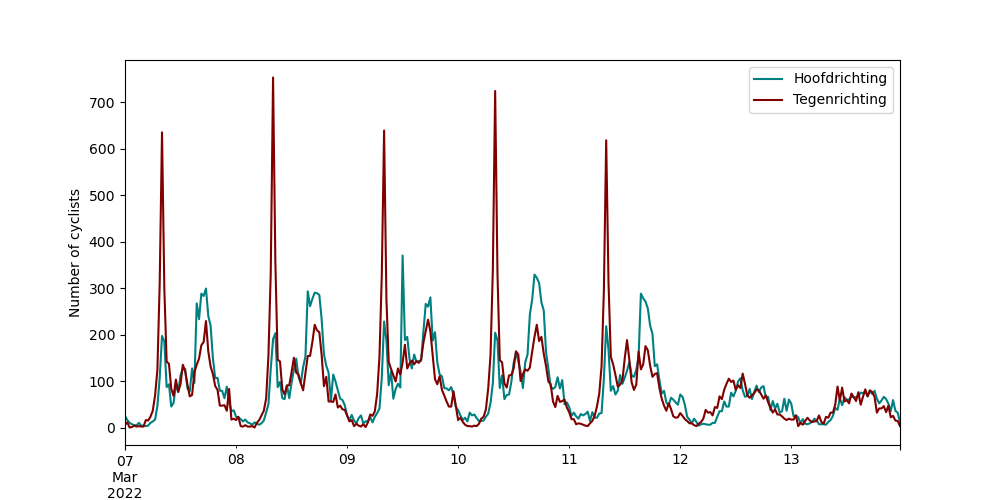

In [28]:
# Get the data for the counter at Coupure in a dataframe
data_coupure_2022 = get_data(filename="fietstelpaal-coupure-links-2022-gent.csv")

# Plot the data for the week starting 7 march 2022 and ending 13 march 2022
plot_bicycles(data_bikes=data_coupure_2022, start_time='2022-03-07', end_time='2022-03-13')

### Groendreef

We can do something similar for the counter at 'Groendreef' and see the same pattern.

- Hoofdrichting: to Zuidkaai
- Tegenrichting: to Rooigemlaan

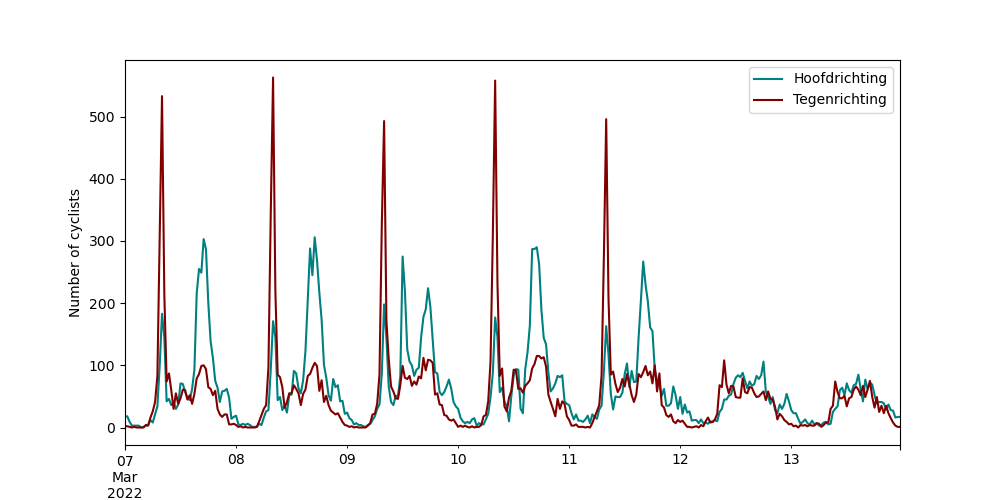

In [29]:
# Get the data in a dataframe
data_groendreef_2022 = get_data(filename="fietstelpaal-groendreef-2022-gent.csv")

plot_bicycles(data_bikes=data_groendreef_2022, start_time='2022-03-07', end_time='2022-03-13', interval="30min")

### Bataviabrug

A similar but less clear pattern can be seen at the counter at the Bataviabrug. Specifically, the difference between weekdays and weekends is less clear. Of course, this counter is not located on a busy main road. So this might lead us to suspect that less commuting traffic takes place along this road. Whether this is effectively the case, we will come back to this later.

- Hoofdrichting: to Schipperskaai
- Tegenrichting: to Stapelplein

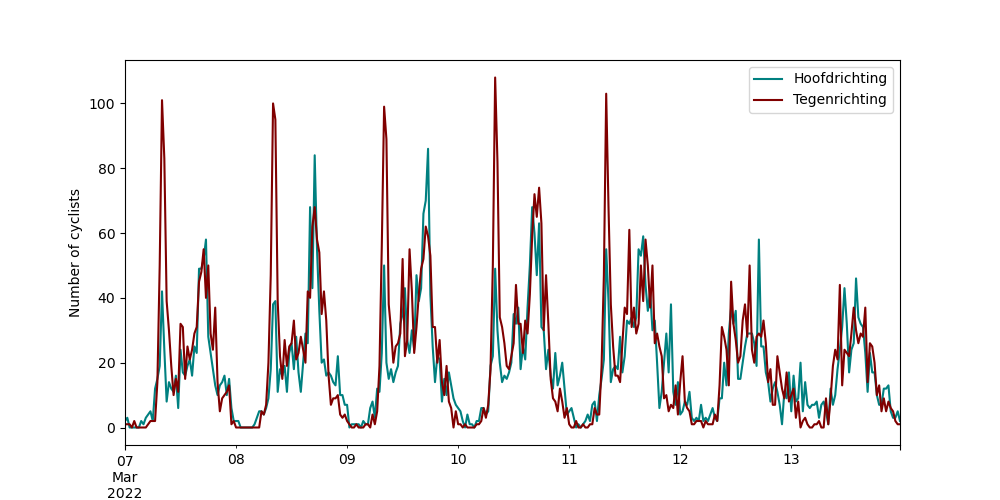

In [30]:
# Get the data in a dataframe
data_batavia_2022 = get_data(filename="fietstelpaal-bataviabrug-2022-gent.csv")

plot_bicycles(data_bikes=data_batavia_2022, start_time='2022-03-07', end_time='2022-03-13', interval="30min")

### Zuidparklaan

In analogy, here are the results for the counter at 'Zuidparklaan'.

- Hoofdrichting: to Woodrow Wilsonplein
- Tegenrichtin: to Sint-Lievenspoort

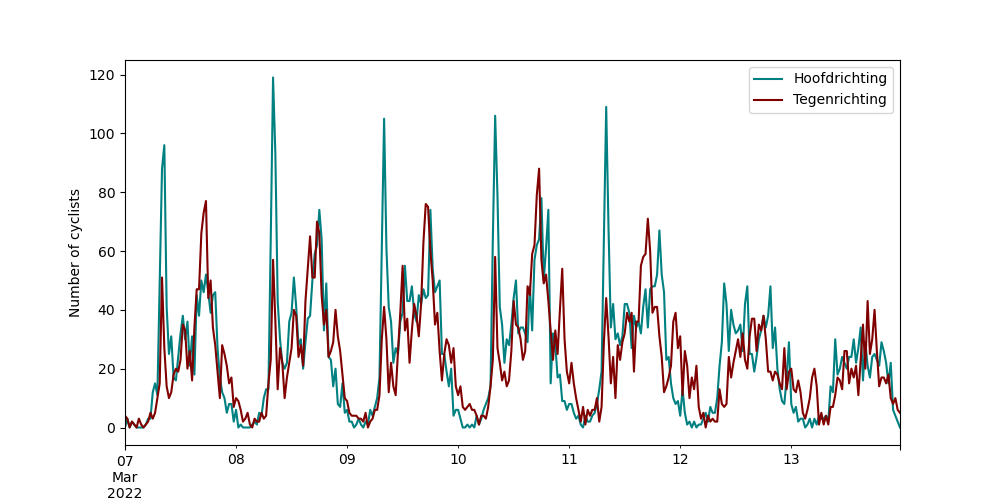

In [31]:
# Get the data in a dataframe
data_zuidpark_2022 = get_data(filename="fietstelpaal-zuidparklaan-2022-gent.csv")

plot_bicycles(data_bikes=data_zuidpark_2022, start_time='2022-03-07', end_time='2022-03-13', interval="30min")

## Fluctuations at weekly level during the year

What follows now is a lot of code that filters the signal. This makes it possible to ignore all small-scale fluctuations and leave only the weekly and yearly fluctuations.

In [32]:
def get_spectrum(data_bikes):

    # Transform totaal signal to array
    array = data_bikes.to_numpy()
    signal = array[ :,0]

    # Calculate the spectrum and the frequencies
    spectrum = rfft(signal)
    freqs = rfftfreq(len(signal), 1/288)

    return signal, spectrum, freqs

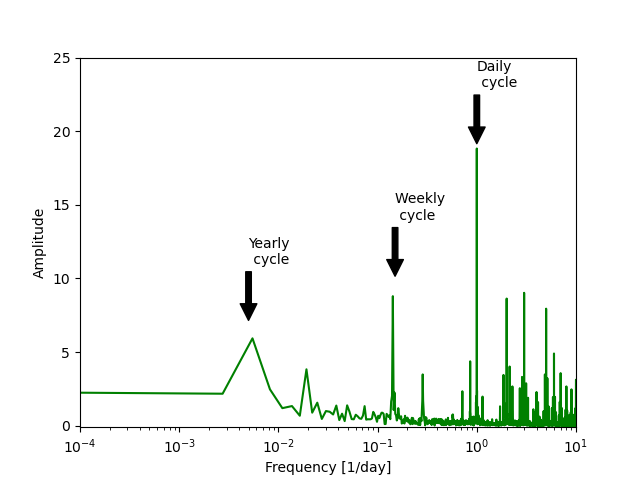

In [33]:
def spectrum_plot(data_bikes):

    # Get the spectrum data
    signal, spectrum, freqs = get_spectrum(data_bikes)

    # Plot spectrum data
    fig, ax = plt.subplots()

    ax.plot(freqs, abs(spectrum) / len(spectrum), "-", color="green")
    
    ax.set_xlim(1e-4, 10)
    ax.set_ylim(-0.1, 25)
    ax.set_xscale("log")

    ax.set_xlabel("Frequency [1/day]")
    ax.set_ylabel("Amplitude")

    # Plot some annotations
    ax.annotate(
        "Daily\n cycle",
        xy=(1, 19),
        xytext=(1, 23),
        arrowprops=dict(facecolor="black", shrink=0.04),
    )
    
    ax.annotate(
        "Yearly \n cycle",
        xy=(5 * 0.001, 7),
        xytext=(5 * 0.001, 11),
        arrowprops=dict(facecolor="black", shrink=0.04),
    )
    
    ax.annotate(
        "Weekly \n cycle",
        xy=(0.15, 10),
        xytext=(0.15, 14),
        arrowprops=dict(facecolor="black", shrink=0.04),
    )
    
    plt.show()

spectrum_plot(data_coupure_2022)

In [34]:
def plot_filter_results(data_bikes, max_freq=0.15, begin_time=None, end_time=None, filter_visible=True):

    # Get the spectrum data
    signal, spectrum, freqs = get_spectrum(data_bikes)
    
    # Inverse fourier of filtered signal
    spectrum_f = spectrum * (freqs < max_freq)
    signal_f = irfft(spectrum_f)

    # Get an array of the time values
    time = data_bikes.index.values

    # Plot the results
    fig, (ax0, ax1) = plt.subplots(2, figsize=(8, 8), tight_layout=True)
    
    norm = len(spectrum)
    ax0.plot(freqs, abs(spectrum) / norm, alpha=0.2, label="original")
    ax0.plot(freqs, abs(spectrum_f) / norm, label="filtered", color="green")
    ax0.legend()
    ax0.set_xlim(1e-4, 13)
    ax0.set_xscale("log")
    ax0.set_xlabel("Frequency [1/day]")
    ax0.set_ylabel("Amplitude")
    ax0.set_visible(filter_visible)

    ax1.plot(time, signal_f, color="chocolate")
    ax1.set_xlabel("Time [day]")
    ax1.set_xlim(begin_time, end_time)
    ax1.set_ylabel("Number of cyclists")
    ax1.set_title("Weekly passing cyclists")
    ax1.axvspan(dt.date(2022, 2, 14), dt.date(2022, 4, 2), alpha=0.5)
    ax1.axvspan(dt.date(2022, 4, 19), dt.date(2022, 5, 21), alpha=0.5)
    ax1.axvspan(dt.date(2022, 9, 26), dt.date(2022, 12, 17), alpha=0.5)

    plt.show()


In the following figure, the signal from the counter at the Coupure has been filtered so that only the weekly fluctuations remain.

It is known that a campus of Ghent University is located at this counter. Consequently, we assume that a large proportion of cyclists are students. To demonstrate this, three blue bars are coloured on the figure. These correspond to the academic year. It can now be seen that it is precisely during these periods that the number of cyclists is noticeably higher. This is a clear argument to assume that many cyclists in this period are students.

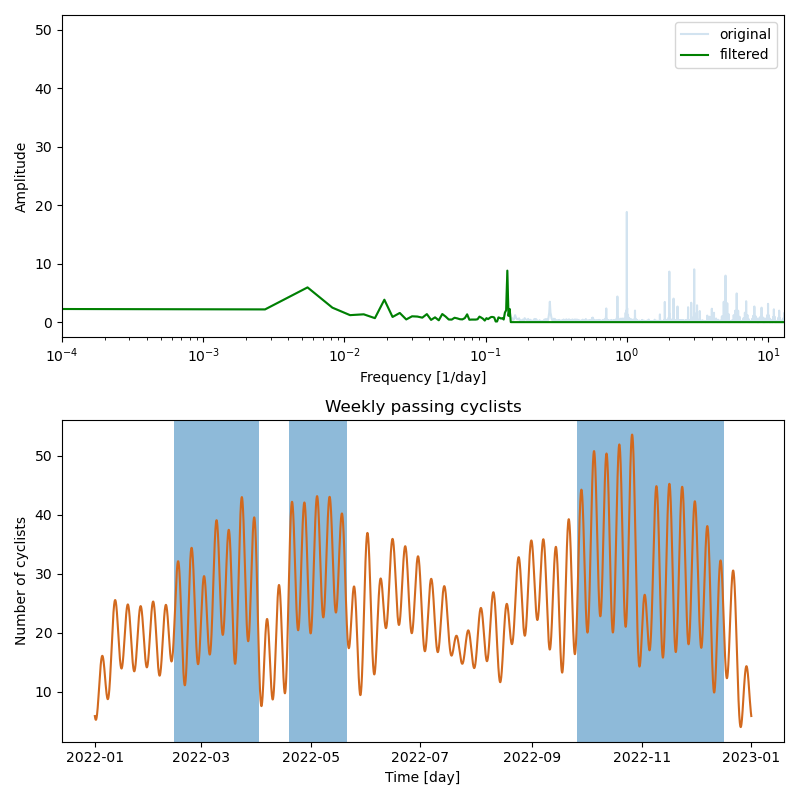

In [35]:
plot_filter_results(data_coupure_2022.fillna(0))

At the counter of the Bataviabrug, we see this effect less sharply than at the Coupure. It is therefore likely to assume that bicycle traffic at the Bataviabrug is less severely affected by commuter traffic.

/tmp/ipykernel_9846/3295856842.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax0, ax1) = plt.subplots(2, figsize=(8, 8), tight_layout=True)


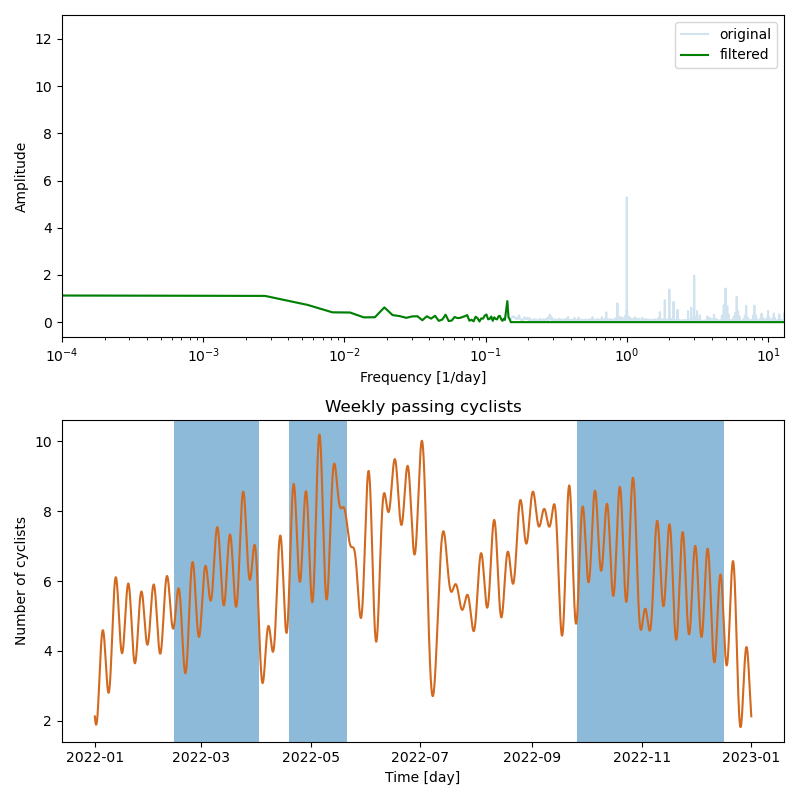

In [36]:
plot_filter_results(data_batavia_2022)